This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch lecture, seminar, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
%pylab inline

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib
import matplotlib.pyplot as plt

import lasagne
from lasagne.layers import batch_norm
import sys
import os

from PIL import Image
import scipy

from scipy.stats import norm
import seaborn as sns
    
np.random.seed(30)

def leakyReLU(x):
    return T.maximum(x,0.2*x)

def invertNL(x):
    return -x

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/env/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fmod', 'log10', 'isclose', 'cos', 'modf', 'cosh', 'sinh', 'fabs', 'log', 'degrees', 'log2', 'inf', 'pi', 'gamma', 'e', 'floor', 'sin', 'exp', 'hypot', 'isinf', 'sqrt', 'copysign', 'tanh', 'nan', 'isfinite', 'trunc', 'radians', 'expm1', 'tan', 'isnan', 'frexp', 'ceil', 'ldexp', 'log1p']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


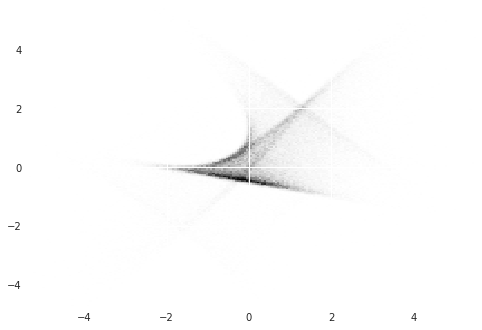

In [8]:
def sample():
    z1 = np.random.randn()
    z2 = np.random.randn()
    z3 = np.random.randn()
    z4 = np.random.randn()
    
    return np.array([(z1+z2)*cos(z2*(1-z2))+0.05*z3, (z1+2)*sin((z2-0.5)*(z2+0.5))+0.05*z4])

dist = np.zeros( (100000, 2))
for i in range(dist.shape[0]):
    dist[i] = sample()

plt.hist2d(dist[:,0],dist[:,1],200)
plt.show()

In [5]:
invar1 = T.matrix()
invar2 = T.matrix()
target = T.ivector()

# Number of variables in the latent space
CONTROLDIM = 8

def build_model():
    net = {}

    net["gen_input"] = lasagne.layers.InputLayer(shape=(None,CONTROLDIM), input_var = invar1 )
    net["gen_layer1"] = lasagne.layers.DenseLayer(net["gen_input"], 16, nonlinearity=leakyReLU)
    net["gen_layer2"] = lasagne.layers.DenseLayer(net["gen_layer1"], 16, nonlinearity=leakyReLU)
    net["gen_layer3"] = lasagne.layers.DenseLayer(net["gen_layer2"], 16, nonlinearity=leakyReLU)
    net["gen_layer4"] = lasagne.layers.DenseLayer(net["gen_layer3"], 16, nonlinearity=leakyReLU)
    net["gen_layer5"] = lasagne.layers.DenseLayer(net["gen_layer4"], 16, nonlinearity=leakyReLU)
    net["gen_dcg_out"] = lasagne.layers.DenseLayer(net["gen_layer5"], 2, nonlinearity = None)
    
    net["inline_disc_1"] = lasagne.layers.DenseLayer(net["gen_dcg_out"], 64, nonlinearity=leakyReLU)
    net["inline_disc_2"] = lasagne.layers.DenseLayer(net["inline_disc_1"], 64, nonlinearity=leakyReLU)
    net["inline_disc_3"] = lasagne.layers.DenseLayer(net["inline_disc_2"], 64, nonlinearity=leakyReLU)
    net["inline_disc_4"] = lasagne.layers.DenseLayer(net["inline_disc_3"], 64, nonlinearity=leakyReLU)
    net["inline_disc_output"] = lasagne.layers.DenseLayer(net["inline_disc_4"], 2, nonlinearity=lasagne.nonlinearities.softmax)
    
    net["disc_input"] = lasagne.layers.InputLayer(shape=(None,2), input_var = invar2 )
    net["disc_1"] = lasagne.layers.DenseLayer(net["disc_input"], 64, nonlinearity=leakyReLU, W = net["inline_disc_1"].W, b = net["inline_disc_1"].b)
    net["disc_2"] = lasagne.layers.DenseLayer(net["disc_1"], 64, nonlinearity=leakyReLU, W = net["inline_disc_2"].W, b = net["inline_disc_2"].b)
    net["disc_3"] = lasagne.layers.DenseLayer(net["disc_2"], 64, nonlinearity=leakyReLU, W = net["inline_disc_3"].W, b = net["inline_disc_3"].b)
    net["disc_4"] = lasagne.layers.DenseLayer(net["disc_3"], 64, nonlinearity=leakyReLU, W = net["inline_disc_4"].W, b = net["inline_disc_4"].b)
    net["disc_output"] = lasagne.layers.DenseLayer(net["disc_4"], 2, nonlinearity=lasagne.nonlinearities.softmax, W = net["inline_disc_output"].W, b = net["inline_disc_output"].b)

    net["inl_gen"], net["inl_disc"] = lasagne.layers.get_output( (net["gen_dcg_out"], net["inline_disc_output"]) )
    net["ofl_disc"] = lasagne.layers.get_output( (net["disc_output"]) )

    net["gan_params"] = lasagne.layers.get_all_params( net["gen_dcg_out"], trainable = True)
    net["disc_params"] = lasagne.layers.get_all_params( net["disc_output"], trainable = True)

    net["gen_loss"] = T.mean(-T.log(net["inl_disc"][:,1]+1e-16))
    net["disc_loss"] = lasagne.objectives.categorical_crossentropy(net["ofl_disc"],target).mean()

    net["updates_gen"] = lasagne.updates.adam(net["gen_loss"], net["gan_params"], learning_rate = 5e-4, beta1=0.5)
    net["updates_disc"] = lasagne.updates.adam(net["disc_loss"], net["disc_params"], learning_rate = 1e-3, beta1 = 0.5)

    net["train_gen"] = theano.function([invar1], net["gen_loss"], updates=net["updates_gen"], allow_input_downcast = True)
    net["train_disc"] = theano.function([invar2,target], net["disc_loss"], updates=net["updates_disc"], allow_input_downcast = True)

    net["process"] = theano.function([invar2,target], net["disc_loss"], allow_input_downcast = True)
    net["gen_images"] = theano.function([invar1], net["inl_gen"], allow_input_downcast = True)
    
    return net

net = build_model()

In [6]:
NEXAMPLES = 1500
HALFBATCH = 1500
DIM = 2

seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1

def generateData(rinp):
    data = net["gen_images"](rinp)
    
    return data

def plot_fig(generate, discriminate):
    # plots pg, pdata, decision boundary
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    # decision boundary
    r = 5000  # resolution (number of points)
    xs = np.float32(np.linspace(-5, 5, r))
    # process multiple points in parallel in same minibatch
    ds = discriminate(xs.reshape(r, 1))
    plt.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs = sample_noise(r)
    gs = generate(zs.reshape(r, 1))
    plt.hist(gs, bins=10, normed=True)

def trainEpoch(eidx):
    for d_iter in range(10):
        seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1
        samples = np.zeros( (NEXAMPLES, DIM ))
        
        # Generate fresh examples
        for i in range(NEXAMPLES):
            samples[i] = sample()
                
        data = generateData(seeds)

        labels = np.zeros( 2*HALFBATCH )
        labels[0:HALFBATCH] = 1
        d_error = net["train_disc"]( samples, labels[0:HALFBATCH] )/2.0
        d_error += net["train_disc"]( data , labels[HALFBATCH:] )/2.0
#         plt.clf()
#         plot_fig(net["train_gen"], net["train_disc"])
#         plt.draw()
        
    
    seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1
    gen_error = net["train_gen"]( seeds )
    
    return gen_error, d_error

def visualize(eidx, show=False):
    seeds = np.random.rand( 100000, CONTROLDIM )*2-1
    data = generateData(seeds)
    plt.hist2d(data[:,0],data[:,1],150,range=[ [-3,3], [-3,4]])
    plt.xlim(-3,3)
    plt.ylim(-3,4)
    if show:
        plt.show()
    else:
        plt.savefig("frames1/%.6d.png" % eidx) # Generate animation frames

In [ ]:
gerr = []
derr = []

for i in range(1000):
    ge,de = trainEpoch(i)
    gerr.append(ge)
    derr.append(de)
    
    if i%10 == 0:
        visualize(i)

plt.plot(gerr,"b-")
plt.plot(derr,"r-")
plt.show()
plt.clf()

plt.hist2d(dist[:,0],dist[:,1],150,range=[ [-3,3], [-3,4]])
plt.show()
plt.clf()

visualize(1000,show=True)